<a href="https://colab.research.google.com/github/ZosoV/aco_random_walk/blob/main/notebooks/random_maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
# Random Maze Generation

In this notebook, we implemented an algorithm for generate a random maze given a graph.

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#%cd /content/gdrive/MyDrive/Proyectos/aco_random_walk/

/content/gdrive/MyDrive/Proyectos/aco_random_walk


In [1]:
%cd /home/zosov/ACO_Random_Walk/
!ls

/home/zosov/ACO_Random_Walk
LICENSE    environment.yml  notebooks	 stuff	     utils
README.md  model	    random_walk  test_rw.py


In [2]:
# import needed libraries

import model.graph_env as ge
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image


In [3]:
UNVISITED, WALL, CELL = 'u', 'w', 'c'
SAVING_DIR = "stuff/results/"
DATA_DIR = "stuff/data/"

For building random maze, we follow the [Randomized Prim’s Algorithm](https://en.wikipedia.org/wiki/Maze_generation_algorithm) variant according to the following base algorithm [Fun With Python #1: Maze Generator](https://medium.com/swlh/fun-with-python-1-maze-generator-931639b4fb7e)

Randomized Prim’s Algorithm consists of the following steps:

1. Start with a grid full of walls
2. Pick a cell, mark it as part of the maze. Add the walls of the cell to the walls of the list
3. While there are walls in the list:

  3.1. Pick a random wall from the list. If only one of the two cells that the wall divides is visited, then:
    
    a. Make the wall a passage and mark the unvisited cell as part of the maze

    b. Add the neighboring walls of the cell to the wall list.

2. Remove the wall from the list
Let’s take a look and see how we can automate this.

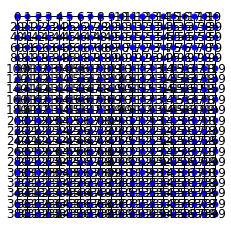

In [34]:
# 1. start a grid full, in our case we based in a graph representation
# and use the PPGraph class

graph = ge.PPGraph(size = 20, tau_0 = 0.1)
graph.draw_graph(with_labels= True)

In [39]:
class RandomMazeGenerator():
    
    def __init__(self,graph):
        self.graph = graph
        self.size = graph.size
        self.starting_node = int(graph.size * graph.size / 2 + (graph.size/2))
        self.entry_node = 0
        self.target_node = graph.size * graph.size - 1
        #print("Starting to create the random maze from node : ",self.starting_node)
        
        self.reset_generator()
        
        
    def reset_generator(self):
        # Mark all the nodes as non visited       
        for i in range(self.size*self.size):
            self.graph.nodes[i]['type'] = UNVISITED
            
        # Mark the initial node as cell
        self.graph.nodes[self.starting_node]['type'] = CELL
        
    def detecting_border_nodes(self, node):
        is_in_border = False
        if node % graph.size == 0:
            is_in_border = True
        elif node in np.arange(0,self.size):
            is_in_border = True
        elif node in np.arange((self.size-1) * self.size, self.size * self.size):
            is_in_border = True
        elif (node + 1) % self.size == 0:
            is_in_border = True

        return is_in_border

    def adding_walls(self,current_cell, walls_list):
        # identified possible wall [right, left, down, up]
        options = [1, -1, self.size, -self.size]

        for i in options:
            new_wall = current_cell + i
            if not self.detecting_border_nodes(new_wall) \
                and self.graph.nodes[new_wall]['type'] == UNVISITED \
                and not new_wall in walls_list:

                walls_list.append(new_wall)
                self.graph.nodes[new_wall]['type'] = WALL

        return walls_list

    def just_one_cell(self,rand_wall):
        s_cells = 0
        movements = [1, -1, self.size, -self.size]
        for i in movements:
            if (self.graph.nodes[rand_wall + i]['type'] == CELL):
                s_cells += 1

        return s_cells < 2
    
    def fix_start_final(self):
        
        # Convert the border nodes to CELLS
        for i in range(0,self.size * self.size):
            if self.graph.nodes[i]['type'] == UNVISITED:
                self.graph.nodes[i]['type'] = WALL

        # Fix start node
        self.graph.nodes[self.entry_node]['type'] = CELL
        #option = np.random.choice([1, self.size])
        self.graph.nodes[self.entry_node + 1]['type'] = CELL
        
        # Fix final node
        self.graph.nodes[self.target_node]['type'] = CELL
        #option = np.random.choice([-1, -self.size])
        self.graph.nodes[self.target_node - 1]['type'] = CELL
        
    def create_random_maze(self, save_transition = False):
        
        self.reset_generator()

        # Adding the initial walls according to the starting node
        walls_list = self.adding_walls(self.starting_node, [])
        
        step = 0
        while walls_list:
            rand_wall = walls_list.pop(np.random.randint(0, len(walls_list)))

            #print("rand_wall: {} , walls_list : {}".format(rand_wall, walls_list))
            options = [(1,-1), (graph.size, -graph.size)]

            for mov1, mov2 in options:
                if self.graph.nodes[rand_wall + mov1]['type'] == CELL and \
                    self.graph.nodes[rand_wall + mov2]['type'] == UNVISITED:
                    
                    if self.just_one_cell(rand_wall):
                        self.graph.nodes[rand_wall]['type'] = CELL

                        walls_list = self.adding_walls(rand_wall, walls_list)

                elif self.graph.nodes[rand_wall + mov1]['type'] == UNVISITED and \
                    self.graph.nodes[rand_wall + mov2]['type'] == CELL:

                    if self.just_one_cell(rand_wall):
                        self.graph.nodes[rand_wall]['type'] = CELL

                        walls_list = self.adding_walls(rand_wall, walls_list)
            
            if save_transition:
                step += 1
                self.draw_maze(node_size = 55, save = save_transition, step = step)
            
        self.fix_start_final()
        
        if save_transition:
            step += 1
            self.draw_maze(node_size = 55, save = save_transition, step = step)
            print("Saving Images from transtion. Total images: ", step)
    
    
    def save_maze(self, idx, dir_path):
        walls = []
        for i in range(self.size*self.size):
            
            if self.graph.nodes[i]['type'] == WALL:
                walls.append(i)
        if self.size + 1 in walls: print("What happend?")
        filename = os.path.join(dir_path,f"maze_size_{self.size}_{idx:04d}.npy")
        np.save(filename, np.array(walls))
        
    def check_feasible_maze(self):
        return self.graph.nodes[self.size + 1]['type'] == CELL and \
                self.graph.nodes[self.size*self.size - self.size - 2]['type'] == CELL            
        
    # Draw maze
    def draw_maze(self, node_size=75, with_labels=False, save = False, step = None):
        """
        Draw the graph.

        node_size: the size of all the nodes
        with_labels: True or False to show the ids of the nodes
        """
        fig, ax = plt.subplots(figsize = (5,5))
        ax.set_aspect('equal') #set the x and y axes to the same scale
        pos = nx.get_node_attributes(self.graph, 'pos')

        # values = []
        # for idx, state in nx.get_node_attributes(self,'state').items():
        values = []
        for _, state in nx.get_node_attributes(self.graph,'type').items():
            if state == CELL:
                values.append(1.0)
            elif state == WALL:
                values.append(0.0)            
            elif state == UNVISITED:
                values.append(0.5)  

        nx.draw(self.graph, pos, 
                cmap=plt.get_cmap('viridis'), 
                node_color=values, 
                node_size=node_size, 
                with_labels=with_labels, 
                font_color='white',
                edgecolors='black',
                vmin = 0., vmax = 1.0)
        if save:
            plt.savefig(os.path.join(SAVING_DIR, f"maze_generation_transition/transition_maze_{step:04d}.png"))
            plt.close()

In [21]:
maze = RandomMazeGenerator(graph)
maze.create_random_maze()


In [22]:
# make a gif with the images
def make_gif(input_dir, output_dir, num_images = -1, loop = 1):
  files = sorted(glob.glob(input_dir + '/*.png'))
  files = files[:num_images] if num_images != -1 else files
  images = list(map(lambda file : Image.open(file) , files))
  images[0].save(output_dir, save_all = True, append_images = images[1::2], duration = 100 , loop = loop)

In [85]:
transition = 1
make_gif(os.path.join(SAVING_DIR, "maze_generation_transition/"), 
         os.path.join(SAVING_DIR, f"transition_{transition:03d}.gif"))

In [8]:
maze.save_maze(1)

In [41]:
# create several test mazes

options_size = [20,50,70,100]
mazes_per_size = 100

for size in options_size:
    
    dir_path = os.path.join(DATA_DIR,"random_mazes/maze_size_{}".format(size))
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    i = 0
    while i < mazes_per_size:
        graph = ge.PPGraph(size = size)
        maze = RandomMazeGenerator(graph)
        maze.create_random_maze()
        if maze.check_feasible_maze():
            print(i,maze.size + 1, maze.graph.nodes[maze.size + 1]['type'])
            print(i,maze.size*maze.size - maze.size - 2, maze.graph.nodes[maze.size*maze.size - maze.size - 2]['type'])
            maze.save_maze(i,dir_path)
            i +=1

0 11 c
0 88 c
1 11 c
1 88 c
2 11 c
2 88 c
3 11 c
3 88 c
4 11 c
4 88 c
5 11 c
5 88 c
6 11 c
6 88 c
7 11 c
7 88 c
8 11 c
8 88 c
9 11 c
9 88 c
10 11 c
10 88 c
11 11 c
11 88 c
12 11 c
12 88 c
13 11 c
13 88 c
14 11 c
14 88 c
15 11 c
15 88 c
16 11 c
16 88 c
17 11 c
17 88 c
18 11 c
18 88 c
19 11 c
19 88 c
20 11 c
20 88 c
21 11 c
21 88 c
22 11 c
22 88 c
23 11 c
23 88 c
24 11 c
24 88 c
25 11 c
25 88 c
26 11 c
26 88 c
27 11 c
27 88 c
28 11 c
28 88 c
29 11 c
29 88 c
30 11 c
30 88 c
31 11 c
31 88 c
32 11 c
32 88 c
33 11 c
33 88 c
34 11 c
34 88 c
35 11 c
35 88 c
36 11 c
36 88 c
37 11 c
37 88 c
38 11 c
38 88 c
39 11 c
39 88 c
40 11 c
40 88 c
41 11 c
41 88 c
42 11 c
42 88 c
43 11 c
43 88 c
44 11 c
44 88 c
45 11 c
45 88 c
46 11 c
46 88 c
47 11 c
47 88 c
48 11 c
48 88 c
49 11 c
49 88 c
50 11 c
50 88 c
51 11 c
51 88 c
52 11 c
52 88 c
53 11 c
53 88 c
54 11 c
54 88 c
55 11 c
55 88 c
56 11 c
56 88 c
57 11 c
57 88 c
58 11 c
58 88 c
59 11 c
59 88 c
60 11 c
60 88 c
61 11 c
61 88 c
62 11 c
62 88 c
63 11 c
63 8

In [38]:
maze.walls

AttributeError: 'RandomMazeGenerator' object has no attribute 'walls'